In [5]:
import sys
addedpath="/home/chaztikov/Documents/gitcontrib/CorrelatedSpherePacking/YangPackPy/periodic_kdtree/"
sys.path.append(addedpath)
print(sys.path)

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'autumn'
import periodic_kdtree
from periodic_kdtree import PeriodicCKDTree

import scipy.spatial
import time
from mpl_toolkits.mplot3d import Axes3D
import pickle
import gzip
import networkx as netx

def read_input_parameters(param_filename='Parameters.in'):
    input_parameters = np.genfromtxt(param_filename,delimiter='=',dtype=str)
    input_parameters[:,0]
    input_parameters[:,1]

    # input_parameter_names, input_parameter_values = np.split( input_parameters, [1], axis=1)
    input_parameter_names = input_parameters[:,0]
    input_parameter_values = input_parameters[:,1]
    parameters = dict({})
    for name, value in zip(input_parameter_names, input_parameter_values):
    #     print(name)
        #assume parameter is numeric
        try:
            parameters.setdefault(name, (eval(value)))
        except Exception as e:
            #assume paraemter is string
            try:
                parameters.setdefault(name, value)
            except Exception as e:
                print(e,'\n',name)

    parameters.setdefault('set_leafsize', int(parameters['set_leafsize_factor'] * parameters['num_neighbors']) )
    input_parameter_names=  parameters.keys()
    return parameters

def parameter_values(parameters, *args):
#     print(args)
    return args


def compute_correction(x,r,ineighbors):
    xn = pts[ineighbors]
    rn = radii_scaled[ineighbors]
    dn = np.linalg.norm(x[:,None]-xn,2,axis=0)
    correct = (r[:,None] + rn) - dn * (xn - x[:,None]) / dn
    correct = np.sum(correct, axis=0)
    return correct


def overlap_correction(i, x, r, pts,radii_scaled, kdt, registered, unregistered, dmax, search_radius_factor_of_max_diameter=2, pnorm=2, eps=1e-2):       
    search_radius = search_radius_factor_of_max_diameter * dmax
    ineighbors = kdt.query_ball_point(x, search_radius, pnorm, eps)
    ineighbors = np.array(ineighbors) 
    
    if(ineighbors.shape[0] < 2 ):
        return x,0

    if(ineighbors.shape[0]>2):
        dist_collide = np.linalg.norm(x[None,:] - pts[ineighbors], pnorm)#, axis=2)
    else:
        dist_collide = np.linalg.norm(x[:]-pts[ineighbors], pnorm)

    my_collision_length = radii_scaled[ineighbors] + r


    icollide = (dist_collide < my_collision_length)
    icollidesum = (icollide).sum()
    try:
        if( icollidesum < 1 ):
            reinit_flag = 0
            return x, reinit_flag
        else:
            icollide = np.where(icollide)
            icollneigh = icollide[ineighbors]
            correct = compute_correction(x, r, icollneigh)
            x = x + correct
            x = overlap_correction(i, x, r, pts, periodic_bounds, set_leafsize, registered, unregistered, search_radius, pnorm=2, eps=1e-2)
            return x, reinit_flag

    except Exception:
        print(' \n \n Exception During Collision Check: Re-initialize with new random seed \n \n ')
        print('x ', x)
        print('icollidesum ', icollidesum)
        print('r ', r)
        print('registered ', len(registered))
        print('unregistered ', len(unregistered))
        reinit_flag = 1
        return x, reinit_flag
    
    return correct,0


def compute_all_overlap(pts, neighbors, nsamples, collision_length_factor):
    dist_collide = np.linalg.norm(pts[neighbors[:,0:1]]-pts[neighbors[:,1:]], axis=2)
    icollide = dist_collide < collision_length_factor
    icollide = np.where(icollide)
    pcoll, ncoll = icollide
    pcoll = np.unique(pcoll)
    ncoll = np.unique(ncoll)

    num_pcoll = np.unique(icollide[0]).shape[0] 
    num_ncoll = np.unique(icollide[1]).shape[0]
    (num_pcoll / nsamples), (num_ncoll / nsamples)
    return icollide, pcoll, ncoll, num_pcoll, num_ncoll


def where_boundary_intersect(parameters, pts,radii_scaled):
    xmin,xmax=parameters['xmin'],parameters['xmax']
    ymin,ymax=parameters['ymin'],parameters['ymax']
    zmin,zmax=parameters['zmin'],parameters['zmax']
    
    cond = (pts**2).sum(axis=1)-radii_scaled**2 > xmax**2
    cond = cond + ((pts**2).sum(axis=1)-radii_scaled**2 < xmin**2)
    cond = cond + ((pts**2).sum(axis=1)+radii_scaled**2 > ymax**2)
    cond = cond +((pts**2).sum(axis=1)-radii_scaled**2 < ymin**2)
    cond = cond + ((pts**2).sum(axis=1)+radii_scaled**2 > zmax**2)
    cond = cond +((pts**2).sum(axis=1)-radii_scaled**2 < zmin**2)
    return cond, cond.sum()


def get_reflected_pts(pts,radii_scaled,xmin,xmax):
    sz0 = pts.shape[0]
    ptsr = pts**2 - radii_scaled[:,None]**2 
    ip1 = np.any(ptsr < xmin,axis=1)
    pts1 = np.mod(ptsr[ip1],xmax-xmin)
    pts = np.vstack((pts,pts1))
    radii_scaled = np.concatenate((radii_scaled,radii_scaled[ip1]))

    ptsr = pts**2 + radii_scaled[:,None]**2
    ip1 = np.any(ptsr > xmax,axis=1)
    pts1 = np.mod(ptsr[ip1],xmax-xmin)
    pts = np.vstack((pts,pts1))
    radii_scaled = np.concatenate((radii_scaled,radii_scaled[ip1]))
    sz = np.unique( pts ,axis=0).shape[0]
    print(sz,sz0)
    flag = 1 if( sz==sz0) else 0
        
    return pts, radii_scaled, flag


def Run_Correlated_Sphere_Packing(input_parameters_filename='Parameters.in', seed_increment = 0):
    parameters = read_input_parameters(input_parameters_filename)
    reinit_flag=0

    '''increment in case of reinitialization'''
    parameters['seed']+=seed_increment

    '''use input parameters'''
    ndimensions,xmin,xmax,ymin,ymax,zmin,zmax,num_neighbors,set_leafsize_factor,periodic_geometry,kdt_eps,pnorm,filename,radii_dist,radius_mu,radius_sig2,nbins,nsamples,show_hist,target_porosity,percentilemin,percentilemax,find_all_neighbors,search_radius_factor_of_max_diameter,set_dt,blfac,damping,tstep,tprint,tstepmax,force_abstol,fmin,force_absmax_factor,force_reltol,max_overlap_factor,seed,Cmu,Csig,set_leafsize \
    =parameter_values(parameters, *parameters.values())
#     print(xmin,xmax)
    RandomState = np.random.RandomState(seed)

    '''form uniform hexahedral mesh'''
    ncells = nsamples
    xx=np.linspace(xmin,xmax,ncells+1)
    dcell = np.diff(xx)[0]
    domain_volume = (xmax-xmin)**3

    periodic_bounds = np.array([xmax,ymax,zmax])[:ndimensions]



    #PART I
    '''sample radii'''
    # #sample radii 
    # while target_porosity < v0:
    # v0 = (radii**3 * 4*np.pi/(3 * (xmax-xmin)**3))
    # v0 = v0/v0.sum()
    if(radii_dist=='lognormal'):
        mu = np.log(radius_mu)
        sig2 = radius_sig2
        Z = RandomState.lognormal(mu,sig2,nsamples)
        radii = np.exp(Z)

    if(show_hist==True):
        plt.hist(radii,nbins)
        plt.show()

    pmin = np.percentile(radii,percentilemin),
    pmax = np.percentile(radii,percentilemax)
    radii = radii[radii<pmax]
    radii = radii[radii>pmin]
    nsamplesclip = nsamples - radii.shape[0]
    nsamples = radii.shape[0]# - nsamplesclip
    radii = np.sort(radii)


    
    
    print('1,99 percentiles ', pmin,pmax)
    print('max, min, mean', radii.max(),radii.min(),radii.mean())



    '''rescale radii to obtain desired porosity'''
    rscale = ( (  np.sum(4*np.pi*(1/3.) * radii**3) ) / ( domain_volume * target_porosity ) )**(1/3)
    radii_scaled = radii/rscale
    radius_mu_scaled = radius_mu / rscale
    radius_sig2_scaled = radius_sig2 / rscale**2
    rmax = ( radii_scaled ).max()
    dmax = 2*rmax
    delta = dcell - 2*rmax
    search_radius = 2*dmax#+delta




    '''sample isotropic gaussian correlation'''
    Cnorm = RandomState.multivariate_normal(Cmu,Csig,nsamples)#,[nsamples,ndimensions])

    '''sample points uniformly in space '''
    pts = RandomState.uniform(xmin,xmax,[nsamples,ndimensions])

    '''sort radii and points '''
    radii_scaled = radii_scaled[::-1]
    pts = pts[::-1,:]
    
    '''get nearest neighbor distances'''
    t0 = time.time()

    if(periodic_geometry==True):
        kdt = PeriodicCKDTree(periodic_bounds, pts)
    else:
        kdt = scipy.spatial.KDTree(pts,leafsize=set_leafsize)
    if(find_all_neighbors==True):
        dist,neighbors = kdt.query(pts, k=num_neighbors, eps=kdt_eps, p = pnorm)

        print("NNE time " , time.time()-t0)

        '''sort by func(distances) eg sum'''
        distsum = (dist[:,1:].sum(axis=1))
        distmean = (dist[:,1:].mean(axis=1))
        distmedian = np.median(dist[:,1:],axis=1)
        distmin = (dist[:,1:].min(axis=1))
        distmax = (dist[:,1:].max(axis=1))

        isort_pts = np.argsort(distmedian)
        isort_radii = np.argsort(isort_pts)

        sorted_radii = radii[isort_radii].copy()
        edges = from_neighbors_to_edges(neighbors)[0]

    '''overlap'''
    max_overlap = radius_mu_scaled * max_overlap_factor
    #find neighbors I interesect (in 3/9/27 cells), use centers and radii to move away by dx if ||dx||<overlap_max


    '''BC, EQ separation, pore throat size, collision distances, PD'''
    boundary_layer = [blfac, xmax *(1- blfac)]
    iboundary = np.any(((pts<boundary_layer[0]).astype(int)+(pts>boundary_layer[1]).astype(int)) , axis=1)
    iinterior = np.all((pts>boundary_layer[0]).astype(int)*(pts<boundary_layer[1]).astype(int),axis=1)
    print(iboundary.shape,iinterior.shape)
    iinterior.sum(),iboundary.sum()

    #formerly, scaled_radii was defined another way
    scaled_radii = radii_scaled.copy()
    scaled_radius_mu = radius_mu_scaled.copy()

    num_inclusions_per_dim = int((nsamples)**(1/ndimensions))
    if(find_all_neighbors==True):
        eq_length_factor = (scaled_radii[neighbors[:,0:1]] + scaled_radii[neighbors[:,1:]])
    else:
        eq_length_factor = (4 * np.pi * (1/3) * (scaled_radii**3).mean())**(1/3) * np.array([[1]]) #???
    pore_space_per_particle = (xmax - eq_length_factor.mean()*num_inclusions_per_dim)/num_inclusions_per_dim
    medimean_eq_length = np.median( eq_length_factor.mean(axis=1))
    porespace_per_dim = num_inclusions_per_dim * medimean_eq_length
    porespace_per_particle  = (porespace_per_dim / (num_inclusions_per_dim - 1))/2
    scaled_radius_diam = scaled_radius_mu*2
    #set spacing
    collision_length_factor = eq_length_factor.copy()# - pore_space_per_particle /2
    eq_length_factor = eq_length_factor + pore_space_per_particle /2
    horizon_factor = eq_length_factor * 1
    # nneighbors = neighbors.shape[1]
    tsteps = np.arange(0,tstepmax)

    zmin = ymin = xmin
    zmax = ymax = xmax

    (pts.T[-1]-np.mod(pts.T[-1],xmax)).max()
    # pts.T[-1][ (pts.T[-1] - radii.T)>xmax]
    # (p - radii.T)>xmax
    (pts.T[-1]+radii_scaled > xmax).sum()
    ((pts**2).sum(axis=1)+radii_scaled**2 > xmax**2).sum()




    cond, conds = where_boundary_intersect(parameters,pts,radii_scaled)
    conds
    # (np.linalg.norm(pts,2,axis=1)+radii_scaled > xmax).sum()
    # pts.min()



    flag=0
    # while flag==0:
    pts, radii_scaled,flag = get_reflected_pts(pts,radii_scaled,xmin,xmax)
    print(radii_scaled.shape)
    nsamples = radii_scaled.shape[0]
    assert(radii_scaled.shape[0] == pts.shape[0])


    ''' Detect Collisions and Translate Spheres '''
    registered = []
    unregistered = [i for i in range(nsamples)]
    boundary = []
    t_list = []
    tlast = time.time()
    for i,(x,r) in enumerate(zip( pts , radii_scaled)):
        if(i%1000==0):
            print(i,x,r, time.time())
        if(i==0):
            registered.append(i)
            unregistered.remove(i)
            pts[i] = x
            radii_scaled[i] = r
        else:
            x,reinit_flag = overlap_correction(i, x, r, pts, radii_scaled, kdt, registered, unregistered,dmax, search_radius_factor_of_max_diameter, pnorm=2, eps=kdt_eps)
            if(reinit_flag==1):
                break;
            registered.append(i)
            unregistered.remove(i)
            pts[i] = x
            radii_scaled[i] = r

        t_list.append(time.time() - tlast)
        tlast = time.time()

    if(reinit_flag==1):
        print(" \n Reinitializing Simulation \n")
        return Run_Correlated_Sphere_Packing(seed_increment+1)
    else:
        print("\n No collisions found, continuing.. \n")
    t_list = np.array(t_list)

    registered = np.array(registered)

    pvolumes = radii_scaled**3 * 4 * np.pi / 3 if ndimensions==3 else radii_scaled**2 * np.pi 

    return parameters, radii_scaled, registered, unregistered, pts, pvolumes

['', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/home/chaztikov/.local/lib/python3.6/site-packages', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/python3/dist-packages/IPython/extensions', '/home/chaztikov/.ipython', '/home/chaztikov/Documents/gitcontrib/CorrelatedSpherePacking/YangPackPy/periodic_kdtree/', '/home/chaztikov/Documents/gitcontrib/CorrelatedSpherePacking/YangPackPy/periodic_kdtree/']


In [2]:
parameters = read_input_parameters('Parameters.in')
','.join(np.array([name for name in parameters.keys()]))

'ndimensions,xmin,xmax,ymin,ymax,zmin,zmax,num_neighbors,set_leafsize_factor,periodic_geometry,kdt_eps,pnorm,filename,radii_dist,radius_mu,radius_sig2,nbins,nsamples,show_hist,target_porosity,percentilemin,percentilemax,find_all_neighbors,search_radius_factor_of_max_diameter,set_dt,blfac,damping,tstep,tprint,tstepmax,force_abstol,fmin,force_absmax_factor,force_reltol,max_overlap_factor,seed,Cmu,Csig,set_leafsize'

In [ ]:
parameters, radii_scaled, registered, unregistered, pts, pvolumes = Run_Correlated_Sphere_Packing('Parameters.in')


seed 0


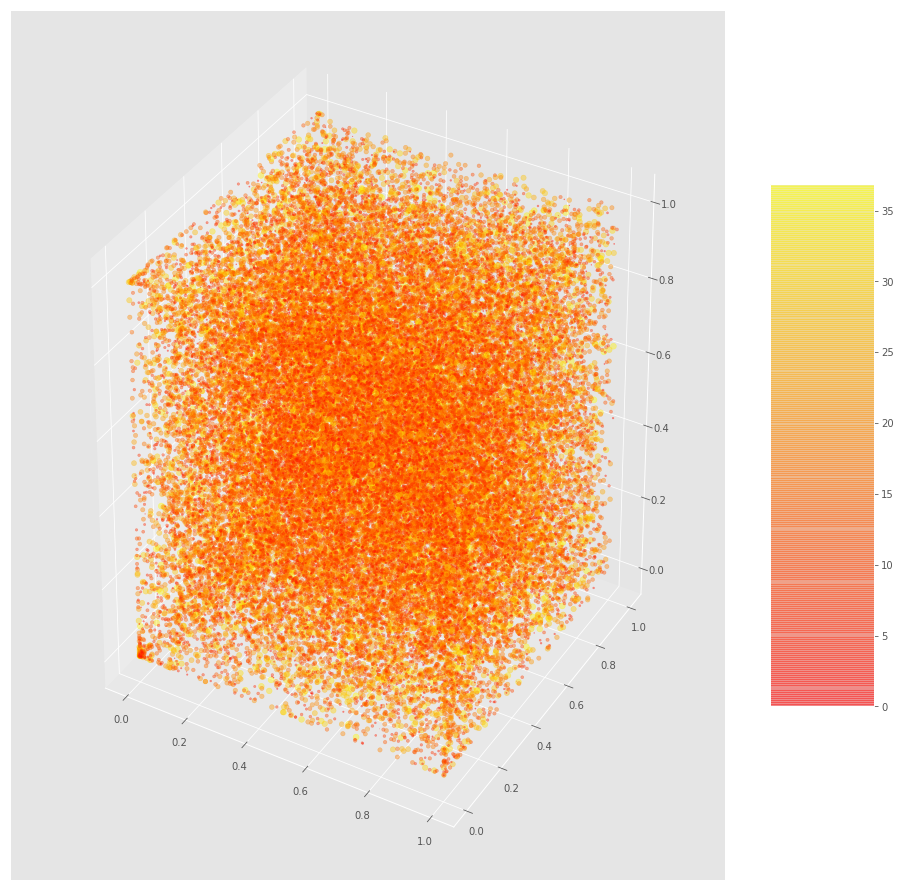

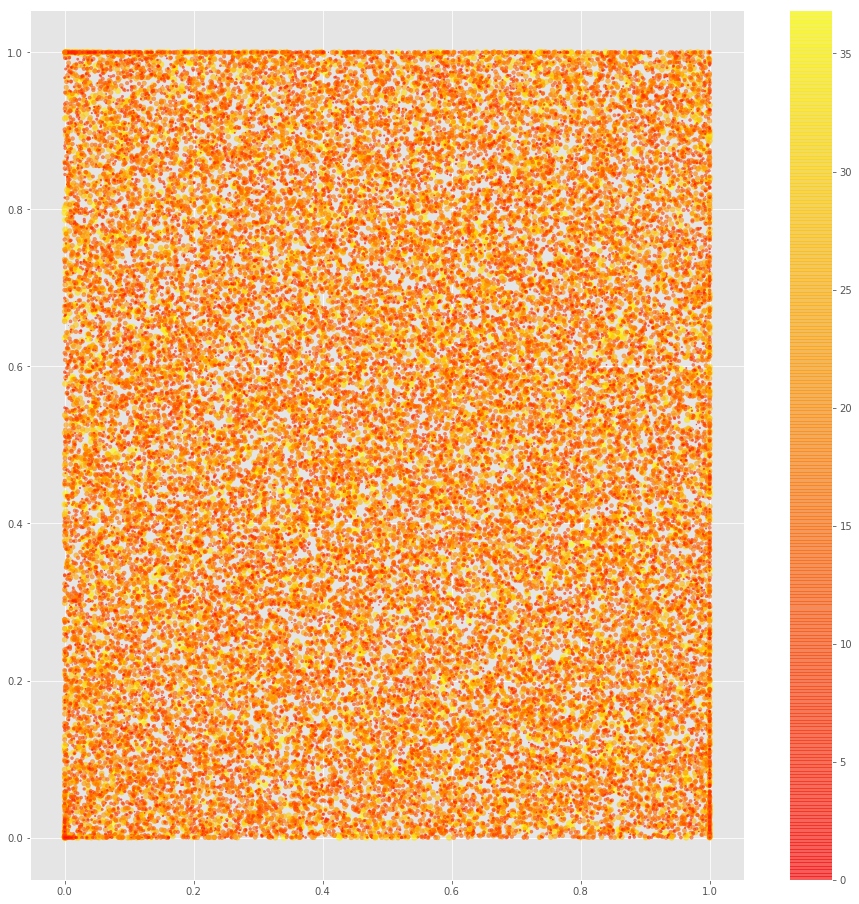

In [9]:
parameters, radii_scaled, registered, unregistered, pts, pvolumes = Run_Correlated_Sphere_Packing('Parameters.in')

seed=parameters['seed']
nsamples = parameters['nsamples']
ndimensions = parameters['ndimensions']

print('seed', seed)
save_filename = 'test_packing'




psize = ((pvolumes-pvolumes.min()))
psize = psize/psize.max()
psize = psize * nsamples**(1/ndimensions) #/16



fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')
X,Y,Z = pts[:,0],pts[:,1],pts[:,2]
cube = ax.scatter(X, Y, Z, zdir='z', s=psize, c=psize,alpha=0.4)
cbar = fig.colorbar(cube, shrink=0.6, aspect=5)
plt.savefig(save_filename+'_3d.png',dpi=200)
plt.show()



# len(),nsamples
plt.figure(figsize=(16,16))
plt.scatter(pts[:,0],pts[:,1],s=psize,c=psize,alpha=0.6)
plt.colorbar()
plt.savefig(save_filename+'_.png',dpi=200)
plt.show()


# plt.figure(figsize=(16,8))
# plt.plot(t_list,'.',alpha=0.4,ms=4);
# plt.ylabel('Time Elapsed Per Iteration ')
# plt.xlabel('Iteration (Sequential Addition)')
# plt.savefig(filename+'_tiame.png',dpi=200)
# plt.show()

# savedict = {'points':pts,
#            'radii_scaled':radii_scaled,
#            'target_porosity':target_porosity,
#             'boundary':boundary
#            }
# filename = 'uncorr_pack_dim_'+str(ndimensions)+'_nparticles_'+str(nsamples)
# with gzip.open(filename + '_.pkl','wb') as f:
#     pickle.dump(savedict,f)


In [4]:
parameters

{'Cmu': [1, 2, 4], 'Csig': array([[1, 0, 0],
        [0, 2, 0],
        [0, 0, 3]]), 'blfac': 0.01, 'damping': 1, 'filename': 'spheres', 'find_all_neighbors': 0, 'fmin': 1000000.0, 'force_absmax_factor': 2, 'force_abstol': 1e-07, 'force_reltol': 1e-08, 'kdt_eps': 0.01, 'max_overlap_factor': 1, 'nbins': 100, 'ndimensions': 3, 'nsamples': 5, 'num_neighbors': 27, 'percentilemax': 95, 'percentilemin': 5, 'periodic_geometry': 1, 'pnorm': 2, 'radii_dist': 'lognormal', 'radius_mu': 1, 'radius_sig2': 0.05, 'search_radius_factor_of_max_diameter': 2, 'seed': 0, 'set_dt': 0.01, 'set_leafsize': 54, 'set_leafsize_factor': 2, 'show_hist': 0, 'target_porosity': 0.3, 'tprint': 100, 'tstep': 0, 'tstepmax': 1000, 'xmax': 1, 'xmin': 0, 'ymax': 1, 'ymin': 0, 'zmax': 1, 'zmin': 0}